Original file is located at
    https://colab.research.google.com/drive/14rKzdYdHjxlcRUPuaP1KJgwvh4YiW7Qp


Create a twitter developer account at:
https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api
    
Familiarize yourself with the Twitter API:
https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api




In [1]:

!pip install pandas
!pip install yfinance
!pip install vaderSentiment
!pip install matplotlib
!pip install numpy
!pip install datetime
!pip install time
!pip install sklearn
!pip install keras
!pip install tensorflow
import pandas as pd
import requests
import json
import pytz
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import sklearn
import tensorflow
from keras.wrappers.scikit_learn import KerasClassifier

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')


ERROR: Could not find a version that satisfies the requirement time
ERROR: No matching distribution found for time


In [2]:
"""### Authentication
Replace consumer_key and consumer_secret with the API key and secret provided to you when your Twitter developer account is created
"""
#get keys locally stored on grace's pc
key = open('C:/Users/gvlev/Desktop/JPMC Stuff/JPMCMemeStocksAPIKey.txt', 'r')
keysecret = open('C:/Users/gvlev/Desktop/JPMC Stuff/JPMCMemeStocksAPIKeySecret.txt', 'r')

def get_bearer_token(key, secret):
    bearer_token_url = "https://api.twitter.com/oauth2/token"
    response = requests.post(bearer_token_url,auth=(key, secret),data={'grant_type': 'client_credentials'},
                             headers={"User-Agent": "TwitterDevFilteredStreamQuickStartPython"},verify=False)
    body = response.json()
    return body['access_token']


def auth():
    consumer_key = key.read() # Add keys here
    consumer_secret = keysecret.read() # Add secret key here
    token = get_bearer_token(consumer_key, consumer_secret)
    return token


def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers



In [3]:
"""### Search for Tweets """

def search_tweets(searchQuery, headers):
    search_tweets = requests.get('https://api.twitter.com/1.1/search/tweets.json?q=$'+str(searchQuery)+'&count=100&result_type=recent', headers=headers)
    return pd.DataFrame.from_records(json.loads(search_tweets.text)['statuses'])

#search for tweets with stock names
def get_twitter_stock_search(list_of_stocks):
    search_df = pd.DataFrame()
    bearer_token = auth()
    headers = create_headers(bearer_token)
    for stock in list_of_stocks:
        try:
            temp_df = search_tweets(stock, headers)
            temp_df['ticker']=stock
            temp_df['created_at'] = pd.to_datetime(temp_df['created_at'], infer_datetime_format=True)
            temp_df = temp_df[temp_df['created_at'].dt.date == datetime.datetime.now(pytz.timezone('US/Eastern')).date()]
            search_df = search_df.append(temp_df)
        except:
            continue
    return search_df



In [4]:
"""### Randomly Collect Tweets"""

def create_url():
    return "https://api.twitter.com/2/tweets/sample/stream?tweet.fields=created_at&expansions=author_id&user.fields=created_at"


def connect_to_stream_endpoint():
    url = create_url()
    bearer_token = auth()
    headers = create_headers(bearer_token)
    stream_list = []
    response = requests.request("GET", url, headers=headers, stream=True)
    for response_line in response.iter_lines():
        if response_line:
            json_response = json.loads(response_line)
            if'data' in json_response:
                stream_list.append(json_response)
            if len(stream_list)==1000:
                r = requests.post(url=url, headers={'Connection':'close'})
                stream_df = pd.DataFrame.from_records(pd.DataFrame.from_records(stream_list)['data'])
                return stream_df



In [5]:
"""### Sentiment Analyzer"""

def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    return sentiment_dict


def apply_vadersentiment(df):
    df['sentiment']=df['text'].apply(lambda x: sentiment_scores(x))
    #set compound score range, classify based on range
    df['sentiment_class']=df['sentiment'].apply(lambda x: 'positive' if x['compound']>0.5 else ('negative' if x['compound']<-0.5 else 'neutral'))
    df['compound score']=df['sentiment'].apply(lambda x: x['compound'])
    return df



In [6]:
"""### Usage"""

    
list_of_stocks = ['GME','AMC','TSLA', 'NOK', 'JPM', 'BAC', 'SBUX', 'AMZN', 'FB']
stocks = {}

#get yfinance info based on ticker 
for stock in list_of_stocks:
    stocks[stock] = yf.Ticker(stock)
twitter_stocks_df = get_twitter_stock_search(list_of_stocks)
twitter_sentiment_df = apply_vadersentiment(twitter_stocks_df)


filter_info = twitter_sentiment_df[["text", "sentiment_class"]] # filter the data 



#renaming columns
twitter_stocks_df.rename({'created_at':'Date', 'ticker':'Stock_Name'}, axis=1, inplace= True)
filteredDat = twitter_stocks_df[['Date', 'text', 'favorite_count', 'favorited', 'retweeted', 'lang', 'quoted_status', 'Stock_Name', 'sentiment', 'sentiment_class', 'compound score']]
#filtered so only tweets in english are considered (vadersentiment only works on english)
engFilter = filteredDat['lang']=='en'
filteredDat = filteredDat[engFilter]

#adding stock price to column
filteredDat['Stock Price'] = filteredDat.apply(
    lambda row: stocks[row.Stock_Name].history(period='1d')['Close'][0], axis=1)
#store data in a csv file
filteredDat.to_csv(r'C:/Users/gvlev/Desktop/JPMC Stuff/JPMC_data_csv2.csv', mode = 'a',index=False, header=True)





In [7]:
#load previous data from csv file
def load():
    return pd.read_csv(r"C:\Users\gvlev\Desktop\JPMC Stuff\JPMC_data_csv1.csv",  parse_dates=['Date'])
def load2():
    return pd.read_csv(r"C:\Users\gvlev\Desktop\JPMC Stuff\JPMC_data_csv2.csv",  parse_dates=['Date'])

totalInfo = load().copy()
totalInfo2 = load2().copy()
totalInfo = totalInfo.append(totalInfo2.iloc[1: , :])

#fill any NaN/invalid values
totalInfo = totalInfo.fillna(0)

#get rid of any noisy data (compound score is zero)
filter = (totalInfo['compound score']!='0') & (totalInfo['compound score']!='0.0')
totalInfo = totalInfo[filter]






In [8]:
#checking for different date formats
def tryCatch(row):
    try:
        return datetime.datetime.strptime(row.Date.split('+')[0], '%m/%d/%y')
    except ValueError:
        try:
            dt = datetime.datetime.strptime(row.Date.split('+')[0], '%Y-%m-%d %H:%M:%S')
            return datetime.date(dt.year, dt.month, dt.day)
        except:
            dt = datetime.datetime.strptime(row.Date.split('+')[0], '%m/%d/%Y')

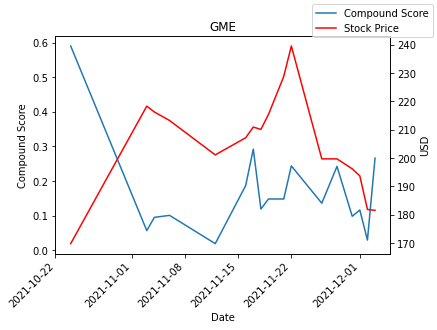

In [28]:

#filter for GME data only
GME = (totalInfo['Stock_Name']=='GME') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
GMEdf = totalInfo[GME]

#format date
GMEdf['Date'] = GMEdf.apply(
    lambda row: tryCatch(row), axis=1)

#convert strings to correct types
GMEdf['Stock Price'] = GMEdf['Stock Price'].astype(float).to_numpy()
GMEdf['compound score'] = GMEdf['compound score'].astype(float)

#group by date, take avg of values
grouped = GMEdf.groupby(['Date'], as_index=False).mean()

#graphing
fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'], label = 'Compound Score')
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("GME")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")

,Date,compound score,Stock Price
0,2021-11-03,0.152687,40.790000
1,2021-11-04,0.112982,39.690000
2,2021-11-06,0.139875,41.700000
3,2021-11-12,-0.020792,39.621749
4,2021-11-16,0.147582,42.599998
5,2021-11-17,0.274039,42.525273
6,2021-11-18,0.260037,40.410000
7,2021-11-19,0.131109,40.457236
8,2021-11-21,0.076474,40.869999
9,2021-11-22,0.279861,40.948271


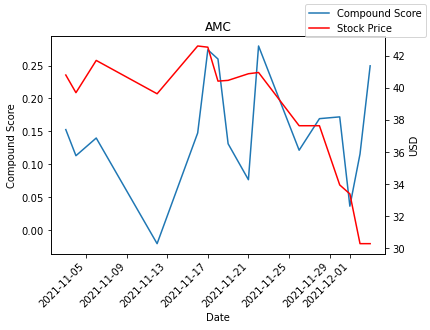

In [27]:
AMC = (totalInfo['Stock_Name']=='AMC') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
AMCdf = totalInfo[AMC]

AMCdf['Date'] = AMCdf.apply(
    lambda row: tryCatch(row), axis=1)

AMCdf['Stock Price'] = AMCdf['Stock Price'].astype(float).to_numpy()
AMCdf['compound score'] = AMCdf['compound score'].astype(float)

grouped = AMCdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'], label= 'Compound Score')
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("AMC")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")


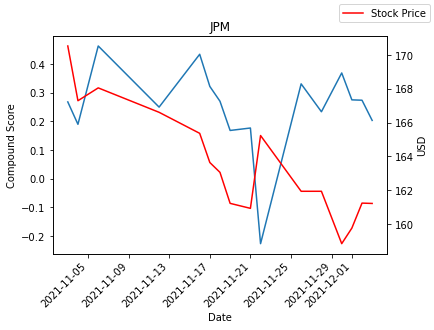

In [29]:
JPM = (totalInfo['Stock_Name']=='JPM') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
JPMdf = totalInfo[JPM]

JPMdf['Date'] = JPMdf.apply(
    lambda row: tryCatch(row), axis=1)

JPMdf['Stock Price'] = JPMdf['Stock Price'].astype(float).to_numpy()
JPMdf['compound score'] = JPMdf['compound score'].astype(float).to_numpy()

grouped = JPMdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("JPM")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")
#ewma exponentially weighted avg


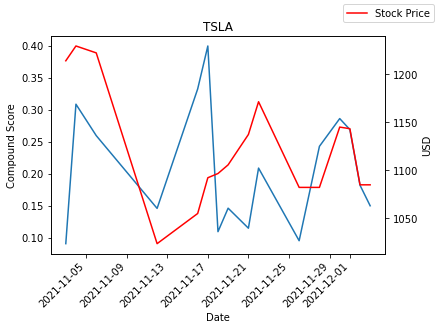

In [33]:
TSLA = (totalInfo['Stock_Name']=='TSLA') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
TSLAdf = totalInfo[TSLA]

TSLAdf['Date'] = TSLAdf.apply(
    lambda row: tryCatch(row), axis=1)

TSLAdf['Stock Price'] = TSLAdf['Stock Price'].astype(float).to_numpy()
TSLAdf['compound score'] = TSLAdf['compound score'].astype(float)

grouped = TSLAdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("TSLA")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")

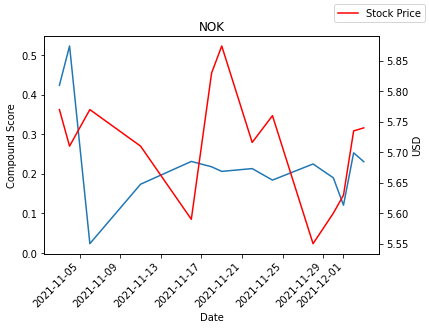

In [34]:
NOK = (totalInfo['Stock_Name']=='NOK') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
NOKdf = totalInfo[NOK]

NOKdf['Date'] = NOKdf.apply(
    lambda row: tryCatch(row), axis=1)

NOKdf['Stock Price'] = NOKdf['Stock Price'].astype(float).to_numpy()
NOKdf['compound score'] = NOKdf['compound score'].astype(float)

grouped = NOKdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("NOK")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")

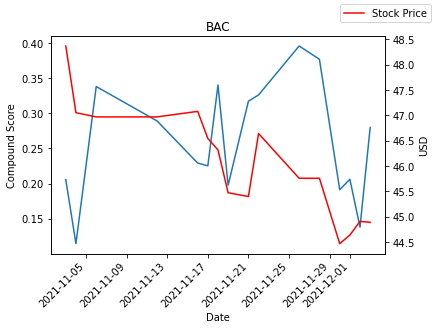

In [35]:

BAC = (totalInfo['Stock_Name']=='BAC')& (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
BACdf = totalInfo[BAC]

BACdf['Date'] =  BACdf.apply(
    lambda row: tryCatch(row), axis=1)

BACdf['Stock Price'] = BACdf['Stock Price'].astype(float).to_numpy()
BACdf['compound score'] = BACdf['compound score'].astype(float).to_numpy()

grouped = BACdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("BAC")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")

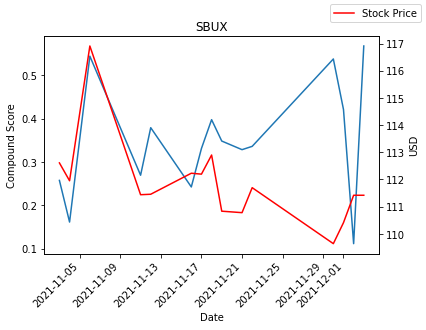

In [36]:
SBUX = (totalInfo['Stock_Name']=='SBUX')& (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
SBUXdf = totalInfo[SBUX]

SBUXdf['Date'] = SBUXdf.apply(
    lambda row: tryCatch(row), axis=1)

SBUXdf['Stock Price'] = SBUXdf['Stock Price'].astype(float).to_numpy()
SBUXdf['compound score'] = SBUXdf['compound score'].astype(float)

grouped = SBUXdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("SBUX")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")

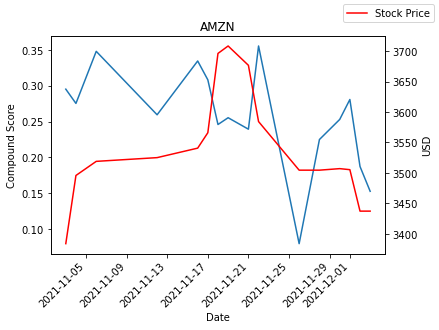

In [37]:
AMZN = (totalInfo['Stock_Name']=='AMZN') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
AMZNdf = totalInfo[AMZN]

AMZNdf['Date'] = AMZNdf.apply(
    lambda row: tryCatch(row), axis=1)

AMZNdf['Stock Price'] = AMZNdf['Stock Price'].astype(float)
AMZNdf['compound score'] = AMZNdf['compound score'].astype(float)

grouped = AMZNdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("AMZN")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")


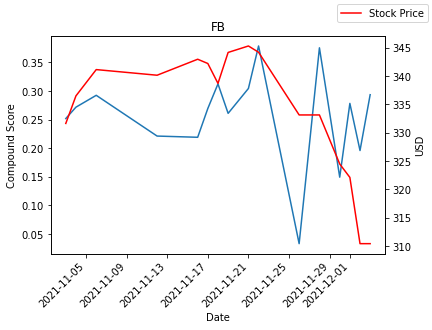

In [38]:
FB = (totalInfo['Stock_Name']=='FB') & (totalInfo['compound score'] != 0)& (totalInfo['Stock Price'] != 0)
FBdf = totalInfo[FB]

FBdf['Date'] = FBdf.apply(
    lambda row: tryCatch(row), axis=1)

FBdf['Stock Price'] = FBdf['Stock Price'].astype(float)
FBdf['compound score'] = FBdf['compound score'].astype(float)

grouped = FBdf.groupby(['Date'], as_index=False).mean()

fig,ax = plt.subplots()
ax.plot(grouped['Date'], grouped['compound score'])
ax.set_xlabel("Date"), ax.set_ylabel("Compound Score"), ax.set_title("FB")
plt.xticks(rotation=45, ha='right')

ax2 = ax.twinx()
ax2.set_ylabel("USD")
ax2.plot(grouped['Date'], grouped['Stock Price'], label = 'Stock Price', color='r')
fig.legend(loc="upper right")
